In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

***Preprocessing***

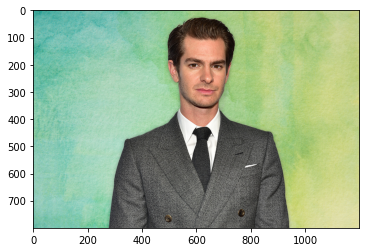

In [2]:
img = cv2.imread('./test_imgs/andrew.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

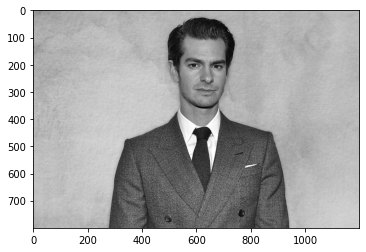

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [4]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces #return array of face(s) (x, y, width, height)

array([[524, 117, 221, 221]])

In [5]:
(x, y, w, h) = faces[0]
x, y, w, h

(524, 117, 221, 221)

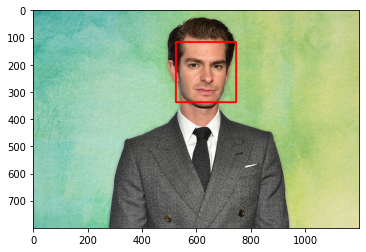

In [6]:
#draw a rectangle around face - photos, coordinates of two angle, in red color (255, 0, 0), thickness
face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 5)
plt.imshow(face_img)

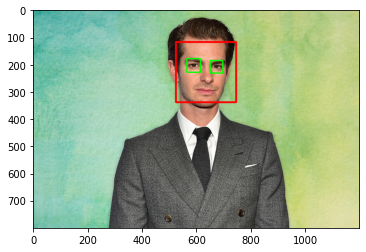

In [7]:
cv2.destroyAllWindows()
#for the face in rectangle
for (x, y, w, h) in faces:
    #draw a rectangle
    face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 5)
    #cut original image with only face
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    #apply eye_cascade to find an eyes
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 3)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

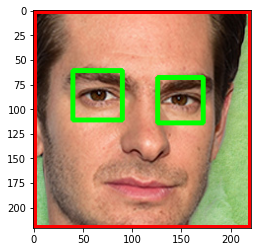

In [8]:
plt.imshow(roi_color, cmap='gray')

In [9]:
#make it in one function
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

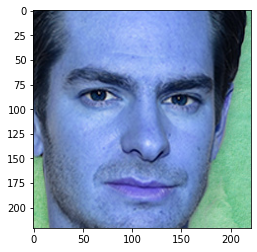

In [10]:
cropped_img = get_cropped_image_if_2_eyes('./test_imgs/andrew.jpg')
plt.imshow(cropped_img)

In [11]:
path_to_data = './imgs'
path_to_crop_data = './imgs/cropped/'

In [12]:
#creating folder for cropped images (delete if already exists)
import shutil
if os.path.exists(path_to_crop_data):
    shutil.rmtree(path_to_crop_data)

In [13]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        

In [14]:
img_dirs

['./imgs\\andrew garfield',
 './imgs\\scarlett johansson',
 './imgs\\simu liu',
 './imgs\\tom holland',
 './imgs\\zoe saldana']

In [15]:
os.mkdir(path_to_crop_data)

In [16]:
cropped_image_dirs = []
actor_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    actor_name = img_dir.split('\\')[-1]
    actor_file_names_dict[actor_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path.replace('\\', '/'))
        if roi_color is not None:
            cropped_folder = path_to_crop_data + actor_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print('Generating cropped images in folder: ', cropped_folder)
                
            cropped_file_name = actor_name + str(count) + ".jpg"
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            actor_file_names_dict[actor_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./imgs/cropped/andrew garfield
Generating cropped images in folder:  ./imgs/cropped/scarlett johansson
Generating cropped images in folder:  ./imgs/cropped/simu liu
Generating cropped images in folder:  ./imgs/cropped/tom holland
Generating cropped images in folder:  ./imgs/cropped/zoe saldana


**Wavelet Transform** This method starts with a mother wavelet such as Haar, Morlet, Daubechies, etc. The signal is then essentially translated into scaled and shifted versions of mother wavelet. </br>
A wavelet is a wave-like oscillation with an amplitude that begins at zero, increases, and then decreases back to zero. It can typically be visualized as a “brief oscillation” like one recorded by a seismograph or heart monitor. </br>
**haar == db1** - For an input represented by a list of 2\**n numbers, the Haar wavelet transform may be considered to pair up input values, storing the difference and passing the sum. This process is repeated recursively, pairing up the sums to prove the next scale, which leads to 2**n-1 differences and a final sum 

In [17]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    '''
    A wavelet coefficient is the scalar product between a function (your observation) and a basis function, 
    the wavelet. In other words, it is the "coordinate" of your function on this wavelet if you do an 
    orthogonal projection.
    '''
    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

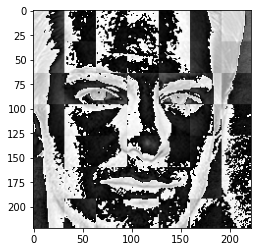

In [18]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [19]:
class_dict = {}
count = 0
for actor_name in actor_file_names_dict.keys():
    class_dict[actor_name] = count
    count = count + 1
class_dict

{'andrew garfield': 0,
 'scarlett johansson': 1,
 'simu liu': 2,
 'tom holland': 3,
 'zoe saldana': 4}

In [20]:
X = []
y = []

for actor_name, training_files in actor_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(scalled_raw_img, 'db1', 5)
        scalled_raw_har = cv2.resize(img_har, (32, 32))
        #храним две фотографии вертикльно 
        combied_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_raw_har.reshape(32*32, 1)))
        X.append(combied_img)
        y.append(class_dict[actor_name])

In [21]:
len(y) #all my images

223

In [22]:
X[0].shape #2D array

(4096, 1)

In [23]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X

array([[ 14.,  26.,  44., ..., 199., 200., 208.],
       [ 21.,  15.,  18., ...,  24.,  38.,  36.],
       [ 58.,  66.,  79., ...,  38.,  17.,  26.],
       ...,
       [  8.,   8.,   8., ..., 168., 166., 182.],
       [143., 155., 135., ..., 221., 217., 207.],
       [ 24.,  26.,  36., ..., 204., 227., 224.]])

In [24]:
X[0].shape #1D array

(4096,)

***Training***

We will use SVM with rbf kernel tuned with heuristic finetuning <br>
A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model sets of labeled training data for each category, they're able to categorize new text. <br>
Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier. Deleting the support vectors will change the position of the hyperplane. These are the points that help us build our SVM. <br>
The RBF kernel function for two points X₁ and X₂ computes the similarity or how close they are to each other.
> When the points are the same, there is no distance between them and therefore they are extremely similar
> When the points are separated by a large distance, then the kernel value is less than 1 and close to 0 which would mean that the points are dissimilar

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [26]:
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
print(r2_score(y_test, predictions))
print(pipe.score(X_test, y_test))

0.11893080697005576
0.7142857142857143


In [27]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       0.67      0.91      0.77        11
           2       1.00      0.67      0.80         9
           3       0.82      0.56      0.67        16
           4       0.82      0.82      0.82        11

    accuracy                           0.71        56
   macro avg       0.75      0.72      0.72        56
weighted avg       0.76      0.71      0.72        56



In [28]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [29]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1, 10, 100, 1000, 10000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    }
}

In [30]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    print(algo)
    print(mp)
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=10, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

svm
{'model': SVC(gamma='auto', probability=True), 'params': {'svc__C': [1, 10, 100, 1000, 10000], 'svc__kernel': ['rbf', 'linear']}}
random_forest
{'model': RandomForestClassifier(), 'params': {'randomforestclassifier__n_estimators': [1, 5, 10]}}
logistic_regression
{'model': LogisticRegression(solver='liblinear'), 'params': {'logisticregression__C': [1, 5, 10]}}


,model,best_score,best_params
0,svm,0.724632,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.510294,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.747426,{'logisticregression__C': 1}


In [31]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [32]:
best_estimators['svm'].score(X_test,y_test)

0.7142857142857143

In [33]:
best_estimators['random_forest'].score(X_test,y_test)

0.5714285714285714

In [34]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8035714285714286

In [35]:
best_clf = best_estimators['logistic_regression']

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  0,  1,  1,  0],
       [ 1, 10,  0,  0,  0],
       [ 0,  0,  9,  0,  0],
       [ 4,  0,  2, 10,  0],
       [ 1,  0,  1,  0,  9]], dtype=int64)

Text(69.0, 0.5, 'Truth')

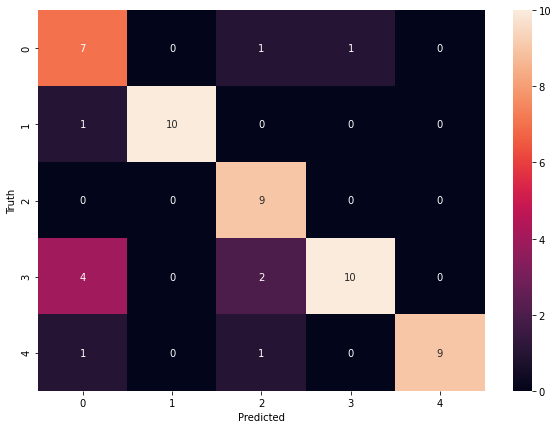

In [37]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
class_dict

{'andrew garfield': 0,
 'scarlett johansson': 1,
 'simu liu': 2,
 'tom holland': 3,
 'zoe saldana': 4}

**Save the trained model**

In [39]:
import joblib

In [40]:
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [41]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))